In [54]:
import joblib
import numpy as np
import pandas as pd
import os

import plotly.express as px
import plotly.figure_factory as ff

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import ( accuracy_score, f1_score, r2_score, mean_squared_error )
from sklearn.model_selection import ( GridSearchCV, train_test_split )
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import( OneHotEncoder, StandardScaler, LabelEncoder )
from sklearn.utils import shuffle

In [55]:
numVotes = [200, 20000]
duree = [40, 150]
year = [1930, 2017]
genre = 8
parentalAdvisor = 5

In [56]:
dataset = pd.read_csv(r'src/dataset.csv', delimiter=',', on_bad_lines='skip')

corr_matrix = round(dataset.corr(), 4)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist(),
                                  )

fig.show()

# numVotes

In [57]:
print(len(dataset))

dfnumVotes = dataset.sort_values(by=['numVotes'])

dfnumVotes = dfnumVotes[dfnumVotes['numVotes'] < numVotes[1]]
dfnumVotes = dfnumVotes[dfnumVotes['numVotes'] > numVotes[0]]

print(len(dfnumVotes))

px.histogram(dfnumVotes["numVotes"])

88648
47417


# duree

In [58]:
dfduree = dfnumVotes.sort_values(by=['duree'])
dfduree = dfduree[dfduree['duree'] < duree[1]]
dfduree = dfduree[dfduree['duree'] > duree[0]]



print(len(dfduree))

px.histogram(dfduree["duree"])

45780


# year

In [59]:
dfyear = dfduree.sort_values(by=['year'])
dfyear = dfyear[dfyear['year'] < year[1]]
dfyear = dfyear[dfyear['year'] > year[0]]

print(len(dfyear))

px.histogram(dfyear["year"])

38592


# genre

29239


<AxesSubplot:>

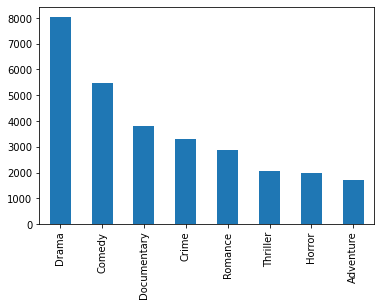

In [60]:
dfgenre = dfyear
countGenre = dfgenre['genre'].value_counts()
countGenre = countGenre[countGenre[:] > countGenre[genre] ]
listGenre = countGenre.keys().tolist()

dfgenre = dfgenre[dfgenre['genre'].isin(listGenre)]

print(len(dfgenre))

countGenre.plot(kind='bar')

# parentalAdvisor

Not Rated    8316
R            7877
PG           2096
Approved     2031
PG-13        1904
Name: parentalAdvisor, dtype: int64
22224


<AxesSubplot:>

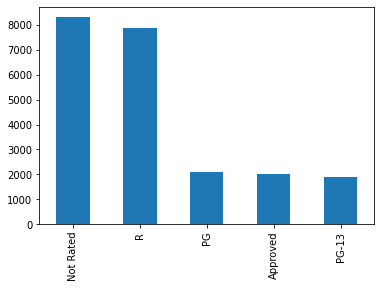

In [61]:
dfparentalAdvisor = dfgenre
countAdvisor = dfparentalAdvisor['parentalAdvisor'].value_counts()

countAdvisor = countAdvisor[countAdvisor[:] > countAdvisor[parentalAdvisor] ] # Drop Less than 5% of biggest genre.
print(countAdvisor)
listGenre = countAdvisor.keys().tolist()

dfparentalAdvisor = dfparentalAdvisor[dfparentalAdvisor['parentalAdvisor'].isin(listGenre)]

print(len(dfparentalAdvisor))

countAdvisor.plot(kind='bar')

# imdbRating

In [62]:
dfimdbRating = dfparentalAdvisor.sort_values(by=['imdbRating'])

print(len(dfimdbRating))

px.histogram(dfimdbRating["imdbRating"])

22224


# Drop Lines 

In [63]:
datasetWithoutOutlier = dfimdbRating.drop(columns=['tconst', 'numVotes'])
datasetWithoutOutlier = shuffle(datasetWithoutOutlier)

In [64]:
target_name = 'imdbRating'

## Graph de correlation 

In [65]:


corr_matrix = round(datasetWithoutOutlier.corr(), 4)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist(),
                                  )


fig.show()

## Separation Varibles / Target

In [66]:
## Separation valeurs explicative et valeur cible
Y = datasetWithoutOutlier[:][target_name]
X = datasetWithoutOutlier.drop(columns= [target_name])

## Separation en train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0, stratify=X['genre'])
# stratify = Y # option pour même ratio de réponse que sur la table Y.
print(X)
print(Y)

       year        genre parentalAdvisor  duree  themaScore
30003  1961    Adventure       Not Rated   79.0    0.270315
71071  1987       Comedy       Not Rated   86.0    0.152308
74342  1967        Drama        Approved  105.0    0.143710
86817  1952       Comedy        Approved   81.0    0.061685
1134   2010  Documentary       Not Rated  106.0    0.480278
...     ...          ...             ...    ...         ...
11296  2010        Crime               R  103.0    0.334633
75276  1986        Drama       Not Rated  137.0    0.139783
24155  2014  Documentary       Not Rated  107.0    0.286879
32493  2007       Comedy               R   90.0    0.260846
56986  2009       Horror       Not Rated   99.0    0.195490

[22224 rows x 5 columns]
30003    4.0
71071    6.7
74342    7.6
86817    6.6
1134     4.2
        ... 
11296    6.4
75276    7.6
24155    7.5
32493    4.1
56986    6.8
Name: imdbRating, Length: 22224, dtype: float64


## Pipeline Préprocessor 

In [67]:
## Médiane quantitative & plus fréquent qualitatif



# Create pipeline for numeric features
numeric_features = X.select_dtypes([np.number]).columns # Automatically detect positions of numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = X.select_dtypes("object").columns # Automatically detect positions of categorical columns
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train) # Preprocessing influenceur
X_test = preprocessor.transform(X_test) # Preprocessing copieur


## Training
### Random Forest

In [68]:
model = RandomForestRegressor(n_jobs=-1, verbose=2) 
# n_jobs=-1 -> Utilisation de tout les cores 
# verbose=2 -> Affiche toutes les info de constructions

## Prediction
### Random Forest model : Grid search

In [69]:

# Grid of values to be tested

params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
'''
params = {
    'max_depth': [4, 6, 8, 10, 12, 14],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 5, 7, 10],
    'min_samples_split': [2, 4, 8, 16, 32, 64],
    'n_estimators': [10, 20, 40, 60, 80, 100, 200]
}
'''
gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
# 36m 6.5s 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    7.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100building tree 5 of 100


building tree 6 of 100
building tree 7 of 100building tree 8 of 100

building tree 9 of 100building tree 10 of 100

building tree 11 of 100building tree 12 of 100
building tree 13 of 100
building tree 14 of 100building tree 15 of 100


building tree 16 of 100
building tree 17 of 100
building tree 18 of 100building tree 19 of 100

building tree 20 of 100
building tree 21 of 100
building tree 22 of 100building tree 23 of 100
building tree 24 of 100

building tree 25 of 100building tree 26 of 100building tree 27 of 100

building tree 28 of 100building tree 29 of 100

building tree 30 of 100

building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100building tree 35 of 100building tree 36 of 100


building tree 37 of 100building tree 38 of 100building tree 39 of 100

building tree 40 of 100

building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.2s


building tree 57 of 100building tree 58 of 100

building tree 59 of 100building tree 60 of 100
building tree 61 of 100

building tree 62 of 100
building tree 63 of 100building tree 64 of 100

building tree 65 of 100
building tree 66 of 100
building tree 67 of 100building tree 68 of 100
building tree 69 of 100
building tree 70 of 100

building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100building tree 78 of 100building tree 79 of 100


building tree 80 of 100
building tree 81 of 100building tree 82 of 100
building tree 83 of 100

building tree 84 of 100building tree 85 of 100

building tree 86 of 100building tree 87 of 100building tree 88 of 100


building tree 89 of 100
building tree 90 of 100building tree 91 of 100

building tree 92 of 100
building tree 93 of 100building tree 94 of 100building tree 95 of 100


building tree 96 of 100
building tree 97 of 100building tree 98 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, verbose=2),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 40, 60, 80, 100]})

In [70]:
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)

...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}


In [71]:
Y_train_pred = gridsearch.predict(X_train) # Predictions on training set
Y_test_pred = gridsearch.predict(X_test) # Prédictions on test set 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


#### Grid search : Random Forest

In [72]:
# Compute mean squared error
mse = mean_squared_error(Y_test, Y_test_pred)
print("Mean squared error : ", mse)
print("Mean error : ", mse**0.5)


Mean squared error :  1.259078265685942
Mean error :  1.1220865678217264


In [73]:
print(f'Number of votes min : {numVotes[0]}, max : {numVotes[1]}')
print(f'Duration min : {duree[0]}, max : {duree[1]}')
print(f'From {year[0]} to {year[1]}')
print(f'{genre} best genres selected')
print(f'{parentalAdvisor} best advisory selected')


fig = px.scatter(x = Y_test, y = Y_test_pred, opacity=0.2, width=650, height=600, marginal_y='violin')
fig.update_layout( margin=dict(l=20, r=10, t=10, b=10), yaxis=dict(scaleanchor="x", scaleratio=1))
fig.show()

Number of votes min : 200, max : 20000
Duration min : 40, max : 150
From 1930 to 2017
8 best genres selected
5 best advisory selected


## Save Model

In [74]:
# save
# joblib.dump(gridsearch.best_estimator_, "export/random_forest.joblib", compress=3)